In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import random
import scipy.stats as stats

In [2]:
# load data: https://www.kaggle.com/datasets/tejashvi14/medical-insurance-premium-prediction?select=Medicalpremium.csv
# data set to predict insurance premium based on demographic/health/other factors.
data = pd.read_csv("../AB/Medicalpremium.csv")
print(data.shape)
data.head()

(986, 11)


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [3]:
# separate outcome and predictors, and scale predictors before model fitting
from sklearn.preprocessing import StandardScaler
colnames = list(data)
X = data[colnames[:-1]]
Xsc = StandardScaler().fit_transform(X)
y = data[colnames[-1]]
Xsc

array([[ 0.23319694, -0.85075039, -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [ 1.30798124,  1.1754329 , -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [-0.41167363,  1.1754329 ,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       ...,
       [ 1.02137209, -0.85075039,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       [ 0.37650152,  1.1754329 ,  1.06498786, ...,  1.9107442 ,
        -0.36514837,  0.44423895],
       [-1.48645793, -0.85075039, -0.93897784, ...,  1.9107442 ,
        -0.36514837,  0.44423895]])

In [10]:
# split data into train and test set
# test data, once we get a model to have good test evaluation scores, will be used to simulate ab test data
test_percentage = 0.2
val_percentage = 0.1
X_train, X_test, y_train, y_test = train_test_split(Xsc, y, test_size=test_percentage, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =val_percentage, random_state = 10)

In [11]:
# fix high learning rate to find optimal number of estimators
# tune n_estimators first, then max_depth and min_child_weight together
# too high of run time if searching through all params at once. use greedy approach
# if only single value of param is listed, it means those are the optimal values for the parameters, 
# found through iterative search
params=[{'n_estimators': [81], 'max_depth': [4], 'min_child_weight':[1]}]
xgb1 = XGBRegressor(learning_rate =0.1, subsample=0.8, 
                    colsample_bytree=0.8, scale_pos_weight=1, seed=10)
gs1 = GridSearchCV(xgb1, param_grid = params, scoring='neg_mean_squared_error',cv = 10)
gs1.fit(X_train,y_train)
gs1.best_params_

{'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 81}

In [12]:
bias_est = np.mean(y_val - gs1.predict(X_val))
bias_est2 = np.mean(y_train - gs1.predict(X_train))
bias_est3 = np.mean(y_test - gs1.predict(X_test))
bias_est, bias_est2, bias_est3

(183.968379153481, 5.644065695521862, 169.57746409406565)

In [13]:
# without considering variance in model

# assume you are randomly assigning incoming stream of observations to treatment or control
# each observation in the stream is randomly chosen with replacement from the remaining data (X_test, y_test)
# if treatment, add constant te to y_ab, otherwise leave it

y_test = y_test.reset_index(drop=True)
random.seed(1)
np.random.seed(1)
# treatment effect (constant)
te = 3000
sim_num = 1000
temp_res = []
sample_size = 40
indx_range = range(0,len(y_test))
predictions = gs1.predict(X_test) + bias_est
for i in range(sim_num):
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1, ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0, ddof=1)
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control, ddof=1)/sample_size)**0.5
    
    # see if decomposing variance for two sample aligns
    treat_var = np.var(treat_y, ddof=1)
    treat_pred_var = np.var(predictions[treat_idx], ddof=1)
    treat_covar = sum(np.multiply(treat_y - predictions[treat_idx]-alpha1, predictions[treat_idx]))*2/(sample_size-1)
    control_var = np.var(control_y, ddof=1)
    control_pred_var = np.var(predictions[control_idx], ddof=1)
    control_covar = sum(np.multiply(control_y - predictions[control_idx] - alpha0, predictions[control_idx]))*2/(sample_size-1)
    
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                    treat_var, treat_pred_var, treat_covar, control_var, control_pred_var, control_covar])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1","alpha1","alpha0","error1","error0",
                                         "treat_var", "treat_pred_var", "treat_covar", "control_var", "control_pred_var", "control_covar"])
    

In [14]:
sim_res.describe()

,two_est,two_se,pair_est,pair_se,pair_se_est1,alpha1,alpha0,error1,error0,treat_var,treat_pred_var,treat_covar,control_var,control_pred_var,control_covar
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.0,1.000000e+03,1.000000e+03,1000.0,1.000000e+03
mean,3019.400000,1389.168752,3018.764606,364.222634,518.379923,2983.141669,-35.622946,5.536807e+06,5.529442e+06,3.863031e+07,27951440.0,5.142059e+06,3.896898e+07,28049504.0,5.390037e+06
std,1404.357365,101.008203,518.920813,62.633247,89.142778,371.989164,372.121513,2.742380e+06,2.626445e+06,7.613177e+06,6028733.0,3.547944e+06,7.746346e+06,6015009.0,3.408126e+06
min,-1125.000000,1057.194522,1198.120923,193.751173,275.756384,1891.972070,-1355.864136,9.803423e+05,1.224575e+06,1.358974e+07,9595169.0,-5.926173e+06,1.508718e+07,12405658.0,-5.675078e+06
25%,2125.000000,1321.298338,2667.744330,318.840774,453.790185,2731.646021,-283.748248,3.362851e+06,3.339185e+06,3.324375e+07,23542394.5,2.685304e+06,3.365849e+07,23779517.0,3.031004e+06
50%,3025.000000,1393.192581,2994.693341,362.270963,515.602202,2973.279626,-56.503857,5.046822e+06,5.178044e+06,3.858173e+07,27652411.0,5.250171e+06,3.845833e+07,27601669.0,5.261256e+06
75%,3975.000000,1450.143669,3370.617566,408.104320,580.834547,3211.964984,225.409027,7.056174e+06,7.152835e+06,4.365833e+07,31846465.5,7.540917e+06,4.398782e+07,32035213.5,7.676769e+06
max,7500.000000,1717.173811,4665.264807,556.525699,792.075302,4456.891626,1220.474927,1.728333e+07,1.543284e+07,6.279423e+07,49860064.0,1.635349e+07,6.384551e+07,49829492.0,1.682536e+07


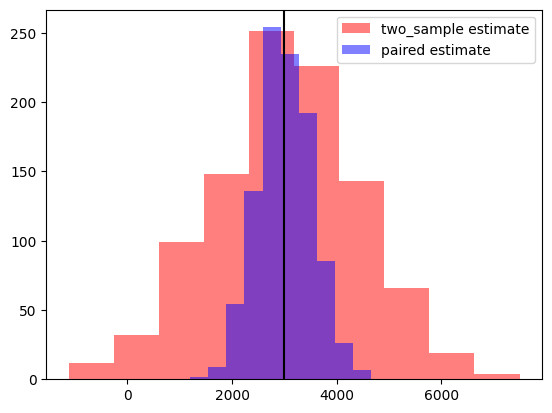

In [15]:
plt.hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
plt.axvline(te, color='black')
plt.legend(loc='upper right') 
plt.show() 

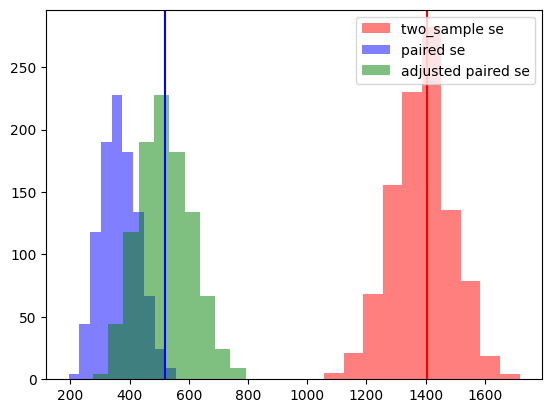

In [16]:
plt.hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

plt.hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
plt.legend(loc='upper right') 
plt.axvline(np.std(sim_res['two_est'],ddof=1), color='red')
plt.axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

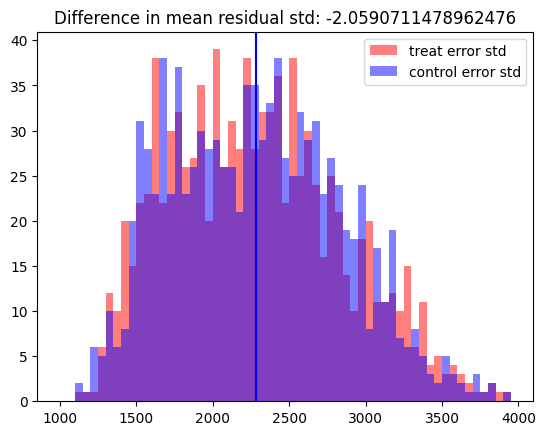

In [17]:
# check if distribution of residuals are the same between control and treat group
plt.hist(np.sqrt(sim_res['error1']),  bins = range(1000,4000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

plt.hist(np.sqrt(sim_res['error0']),  bins = range(1000,4000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
plt.legend(loc='upper right') 
plt.axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
plt.axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
plt.title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

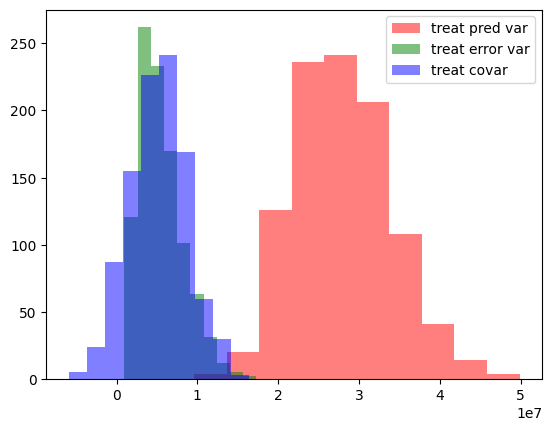

In [18]:
plt.hist(sim_res['treat_pred_var'],  
             alpha=0.5,  
             label='treat pred var', 
             color='red') # customized color parameter 

plt.hist(sim_res['error1'],  
             alpha=0.5,  
             label='treat error var', 
             color='green') # customized color parameter 

plt.hist(sim_res['treat_covar'],  
             alpha=0.5,  
             label='treat covar', 
             color='blue') # customized color parameter 
plt.legend()
plt.show()


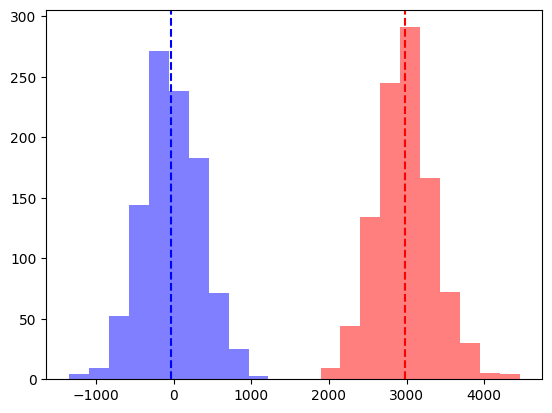

(-35.62294580078125, 2983.14166928711)

In [20]:
plt.hist(sim_res['alpha0'],
        alpha=0.5,
        label='alpha0',
        color='blue')
plt.axvline(np.mean(sim_res['alpha0']), color='blue',linestyle='--')
plt.hist(sim_res['alpha1'],
        alpha=0.5,
        label='alpha1',
        color='red')
plt.axvline(np.mean(sim_res['alpha1']), color='red',linestyle='--')

plt.show()
np.mean(sim_res['alpha0']), np.mean(sim_res['alpha1'])

In [28]:
# train multiple models with same hyper parameters to generate multiple predictions for the test data
# each time, sample with replacement from the train data of the same size
random.seed(1)
np.random.seed(1)
pred_res = []
num_preds = 1000
y_train = y_train.reset_index(drop=True)
n = len(y_train)
index_range = range(n)

for i in range(num_preds):
    # sample train data with replacement from original train data
    bs_index = random.choices(indx_range, k=n)
    X_train_bs = X_train[bs_index,]
    y_train_bs = y_train[bs_index]
    # fit xgb model with the train data
    xgb_bs = XGBRegressor(max_depth = 4, min_child_weight = 1, n_estimators = 81, learning_rate =0.1, subsample=0.8, 
                          colsample_bytree=0.8, scale_pos_weight=1, seed=10)
    xgb_bs.fit(X_train_bs, y_train_bs)
    # generate predictions
    bs_pred = xgb_bs.predict(X_test)
    # debiasing with validation set
    debias_term = np.mean(y_val - xgb_bs.predict(X_val))
    # append debiased predictions
    pred_res.append(bs_pred + debias_term)

bs_preds = pd.DataFrame(pred_res,columns = range(len(y_test)))
bs_preds.describe()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,23732.992188,23128.888672,25801.904297,28348.216797,22407.343750,28613.572266,17889.378906,37084.429688,16170.343750,24467.851562,...,26150.410156,23361.755859,24543.037109,22864.560547,27620.605469,22832.769531,17774.679688,24924.058594,29134.099609,27880.703125
std,501.961456,3055.556885,1228.611328,519.886902,3040.767578,265.798462,1497.483887,1301.203369,693.000977,617.388489,...,487.100281,304.586578,466.043976,377.620056,342.930450,233.919418,767.265686,524.939453,527.640503,482.844086
min,22600.974609,15396.533203,22333.857422,26472.513672,15118.856445,27644.933594,15401.087891,31186.902344,13838.951172,22516.943359,...,24615.099609,22391.091797,23203.011719,21766.804688,26362.044922,21994.890625,15692.562500,23388.812500,28036.076172,26136.806641
25%,23364.455078,21227.349609,24979.080078,28008.280762,20508.598633,28440.061035,16869.663574,36494.269531,15656.377930,24056.364258,...,25841.193848,23158.875488,24210.957031,22613.146484,27398.558594,22677.292969,17256.088867,24574.881836,28729.666992,27553.260254
50%,23690.324219,22953.094727,25776.726562,28351.003906,22273.343750,28599.160156,17671.027344,37387.632812,16118.821289,24467.096680,...,26127.537109,23344.742188,24508.898438,22838.265625,27636.344727,22833.780273,17741.270508,24888.478516,29061.637695,27899.108398
75%,24056.325195,25036.576660,26635.627930,28691.935059,24313.095703,28775.730957,18567.846191,37984.225586,16593.585938,24889.250977,...,26464.951660,23561.641602,24840.244629,23087.985352,27851.391113,22989.293945,18276.295410,25237.107422,29439.345215,28200.368652
max,25577.039062,32663.033203,29656.074219,29989.355469,31228.025391,29636.177734,24400.716797,39791.472656,18976.195312,26351.898438,...,28082.958984,24367.705078,26447.201172,24561.792969,28698.787109,23617.246094,20562.302734,26876.662109,31580.724609,29534.507812


In [29]:
# use various predictions from many models
# not yet taking into account of predictive variance
pred_stds = np.std(bs_preds, ddof=1, axis=0)

# assume you are randomly assigning incoming stream of observations to treatment or control
# each observation in the stream is randomly chosen with replacement from the remaining data (X_ab, y_ab)
# if treatment, add constant te to y_ab, otherwise leave it

random.seed(1)
np.random.seed(1)
# treatment effect (constant)
temp_res = []
sample_size = 50
indx_range = range(0,len(y_test))
for i in range(num_preds):
    # sample with replacement from test data for control and treatment obs, to ensure treatment assignment is indep
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    # select one of the unbiased predictions
    predictions = pred_res[i]
    # estimate params
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
    # generate synthetic obs
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # difference in means est
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    # paired and ac est
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
    # se estimate of ac estimator without pred var
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1","alpha1","alpha0","error1","error0"])
    

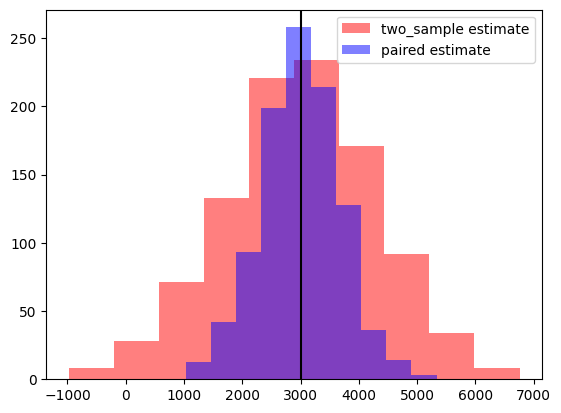

In [30]:
plt.hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
plt.axvline(te, color='black')
plt.legend(loc='upper right') 
plt.show() 

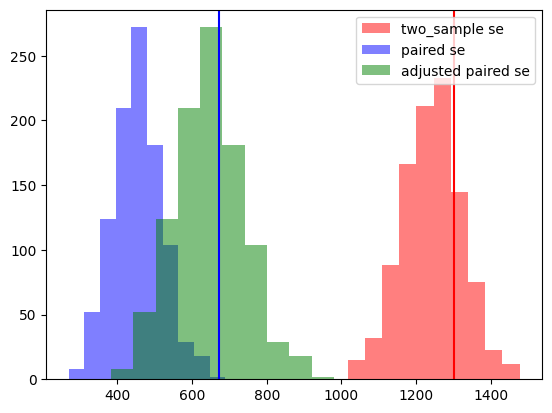

In [31]:
plt.hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
plt.hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

plt.hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
plt.legend(loc='upper right') 
plt.axvline(np.std(sim_res['two_est'],ddof=1), color='red')
plt.axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

In [32]:
# re-simulate results with sample size 80
random.seed(1)
np.random.seed(1)
prediction_vars = np.var(bs_preds, axis=0, ddof=1)
temp_res = []
sample_size = 80
indx_range = range(0,len(y_test))
for i in range(num_preds):
    # sample with replacement for control and treatment obs
    control_idx = random.choices(indx_range, k=sample_size)
    treat_idx = random.choices(indx_range, k=sample_size)
    # simulate treatment outcomes by adding constant te
    control_x = X_test[control_idx,]
    treat_x = X_test[treat_idx,]
    control_y = y_test[control_idx]
    treat_y = y_test[treat_idx] + te
    # choose a random simulation to compute parameters on
    predictions = pred_res[i]
    # compute params
    alpha1 = np.mean(treat_y - predictions[treat_idx])
    alpha0 = np.mean(control_y - predictions[control_idx])
    error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
    error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = predictions[control_idx] + alpha1
    synt_control_obs = predictions[treat_idx] + alpha0
    # estimated paired test te se
    se_est1 = (error1/sample_size + error0/sample_size)**0.5
    # generate combined observations for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test te and se
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    two_sample_se = ((np.var(treat_y, ddof=1) + np.var(control_y,ddof=1))/sample_size)**0.5
    # paired test te and se
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
    # calculate prediction variances to use, based on the observations sampled
    control_mean_pred_var = np.mean(prediction_vars[control_idx])
    treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
    # store results
    temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                    control_mean_pred_var, treat_mean_pred_var])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                          "alpha1","alpha0","error1","error0",
                                          "control_pred_var","treat_pred_var"])
sim_res.describe()    

,two_est,two_se,pair_est,pair_se,pair_se_est1,alpha1,alpha0,error1,error0,control_pred_var,treat_pred_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,2986.887500,985.091712,3000.253370,361.231193,512.472142,2536.839180,-463.414197,1.059509e+07,1.068553e+07,1.053481e+06,1.052408e+06
std,991.468439,50.155789,521.992591,41.001118,58.167543,393.064600,397.386759,3.288147e+06,3.249236e+06,2.261548e+05,2.239445e+05
min,-150.000000,842.368478,1367.066022,238.589724,338.482914,1274.485510,-1630.962598,3.707823e+06,3.409216e+06,4.676914e+05,4.960437e+05
25%,2287.500000,953.657117,2647.791818,335.066659,475.352985,2280.907440,-735.438174,8.282052e+06,8.387655e+06,8.911881e+05,8.945413e+05
50%,3000.000000,986.685993,3033.417499,359.916406,510.606872,2519.189905,-465.957324,1.025012e+07,1.037182e+07,1.035751e+06,1.044720e+06
75%,3640.625000,1017.964625,3354.631075,387.260491,549.399435,2809.863651,-198.423059,1.252567e+07,1.257806e+07,1.196930e+06,1.190254e+06
max,6337.500000,1140.459011,4908.726678,510.422481,724.127117,4100.255359,786.582483,2.611445e+07,2.790019e+07,1.930571e+06,2.035696e+06


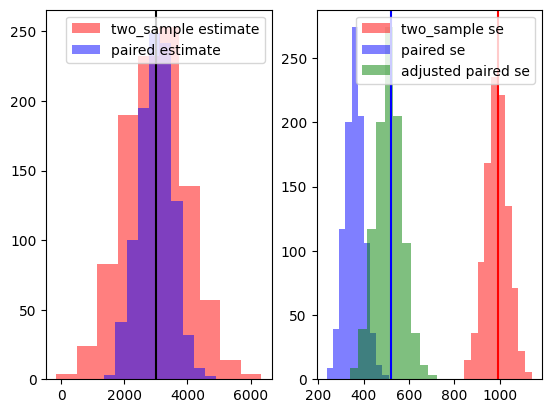

In [33]:
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
 
ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')
ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
plt.show() 

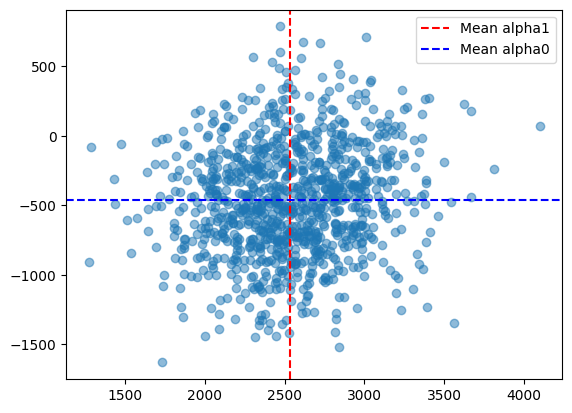

array([[1.       , 0.1278492],
       [0.1278492, 1.       ]])

In [34]:
# Let's first check covariance between alpha1 and alpha0
plt.scatter(sim_res['alpha1'], sim_res['alpha0'], alpha = 0.5)
plt.axvline(np.mean(sim_res['alpha1']), color='red', linestyle = "--", label = "Mean alpha1")
plt.axhline(np.mean(sim_res['alpha0']), color='blue', linestyle = "--", label = "Mean alpha0")
plt.legend()
plt.show()
np.corrcoef(sim_res['alpha1'], sim_res['alpha0'])

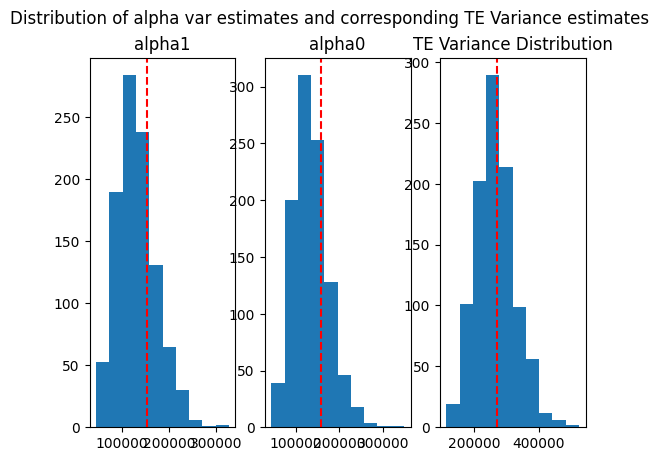

In [35]:
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['error0']/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates")
plt.show()

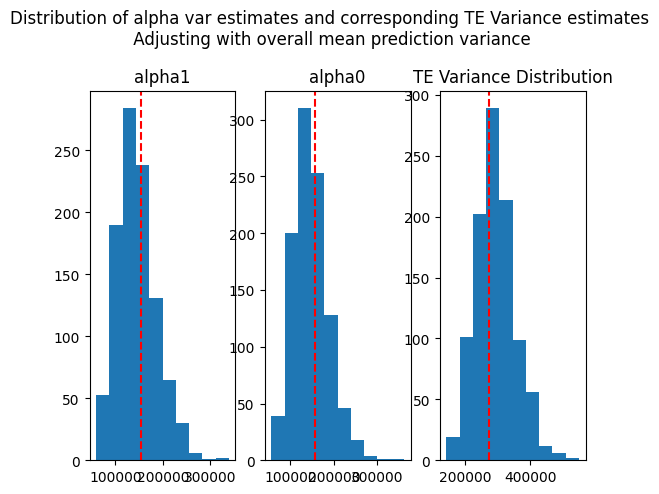

In [36]:
pred_var_est = np.mean(np.var(bs_preds, axis=0, ddof=1))
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size + pred_var_est/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size + pred_var_est/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['error0']/sample_size + 2*pred_var_est/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates\n Adjusting with overall mean prediction variance",
            y = 1.05)
plt.show()

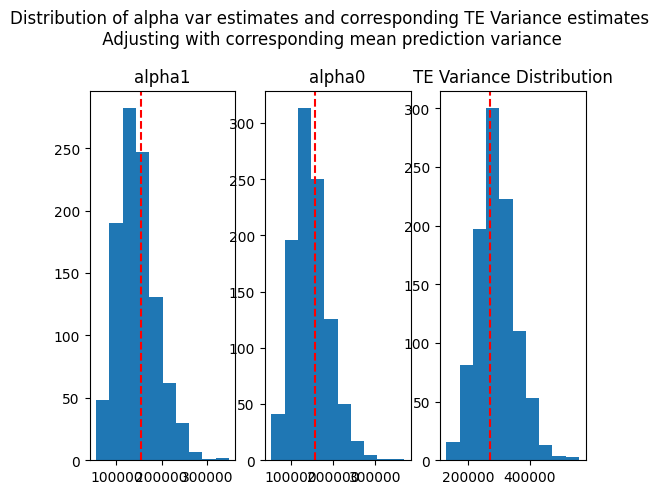

In [37]:
fig, axs = plt.subplots(1, 3)

axs[0].hist(sim_res['error1']/sample_size + sim_res['treat_pred_var']/sample_size)
axs[0].axvline(np.var(sim_res['alpha1']), linestyle = '--', color = 'red')
axs[0].set_title("alpha1")
axs[1].hist(sim_res['error0']/sample_size + sim_res['control_pred_var']/sample_size)
axs[1].axvline(np.var(sim_res['alpha0']), linestyle = '--', color = 'red')
axs[1].set_title("alpha0")
axs[2].hist(sim_res['error1']/sample_size + sim_res['treat_pred_var']/sample_size
            + sim_res['error0']/sample_size + sim_res['control_pred_var']/sample_size)
axs[2].axvline(np.var(sim_res['pair_est']), linestyle = '--', color = 'red')
axs[2].set_title("TE Variance Distribution")
plt.suptitle("Distribution of alpha var estimates and corresponding TE Variance estimates\n Adjusting with corresponding mean prediction variance",
            y = 1.05)
plt.show()

In [38]:
# generate multiple simulations with different group proportions
random.seed(1)
np.random.seed(1)
treat_prop = np.arange(0.1,1,0.1)
sample_size = 80 * 2 # this is the total sample size across both groups. before it was 80 per group but now 160 will be 
# distributed at different rates to each group
indx_range = range(0,len(y_test))
sim_res_df_dic = {}
for j in range(len(treat_prop)):
    temp_res = []
    treat_size = int(sample_size * treat_prop[j])
    control_size = sample_size - treat_size
    for i in range(num_preds):
        control_idx = random.choices(indx_range, k=control_size)
        treat_idx = random.choices(indx_range, k=treat_size)
        control_x = X_test[control_idx,]
        treat_x = X_test[treat_idx,]
        control_y = y_test[control_idx]
        treat_y = y_test[treat_idx] + te
        predictions = pred_res[i]
        alpha1 = np.mean(treat_y - predictions[treat_idx])
        alpha0 = np.mean(control_y - predictions[control_idx])
        error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
        error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
        synt_treat_obs = predictions[control_idx] + alpha1
        synt_control_obs = predictions[treat_idx] + alpha0
        se_est1 = (error1/treat_size + error0/control_size)**0.5
        combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
        combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
        two_sample_te = np.mean(treat_y) - np.mean(control_y)
        two_sample_se = ((1/treat_size + 1/control_size)
                         *(np.var(treat_y, ddof=1)*(treat_size-1) + np.var(control_y, ddof=1)*(control_size-1))
                         /(sample_size - 2))**0.5
        paired_te = np.mean(combined_treat - combined_control)
        paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
        # calculate prediction variances to use, based on the observations sampled
        control_mean_pred_var = np.mean(prediction_vars[control_idx])
        treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
        # store results
        temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                        control_mean_pred_var, treat_mean_pred_var])
        sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                                  "alpha1","alpha0","error1","error0",
                                                  "control_pred_var","treat_pred_var"])
    sim_res_df_dic[treat_prop[j]] = sim_res

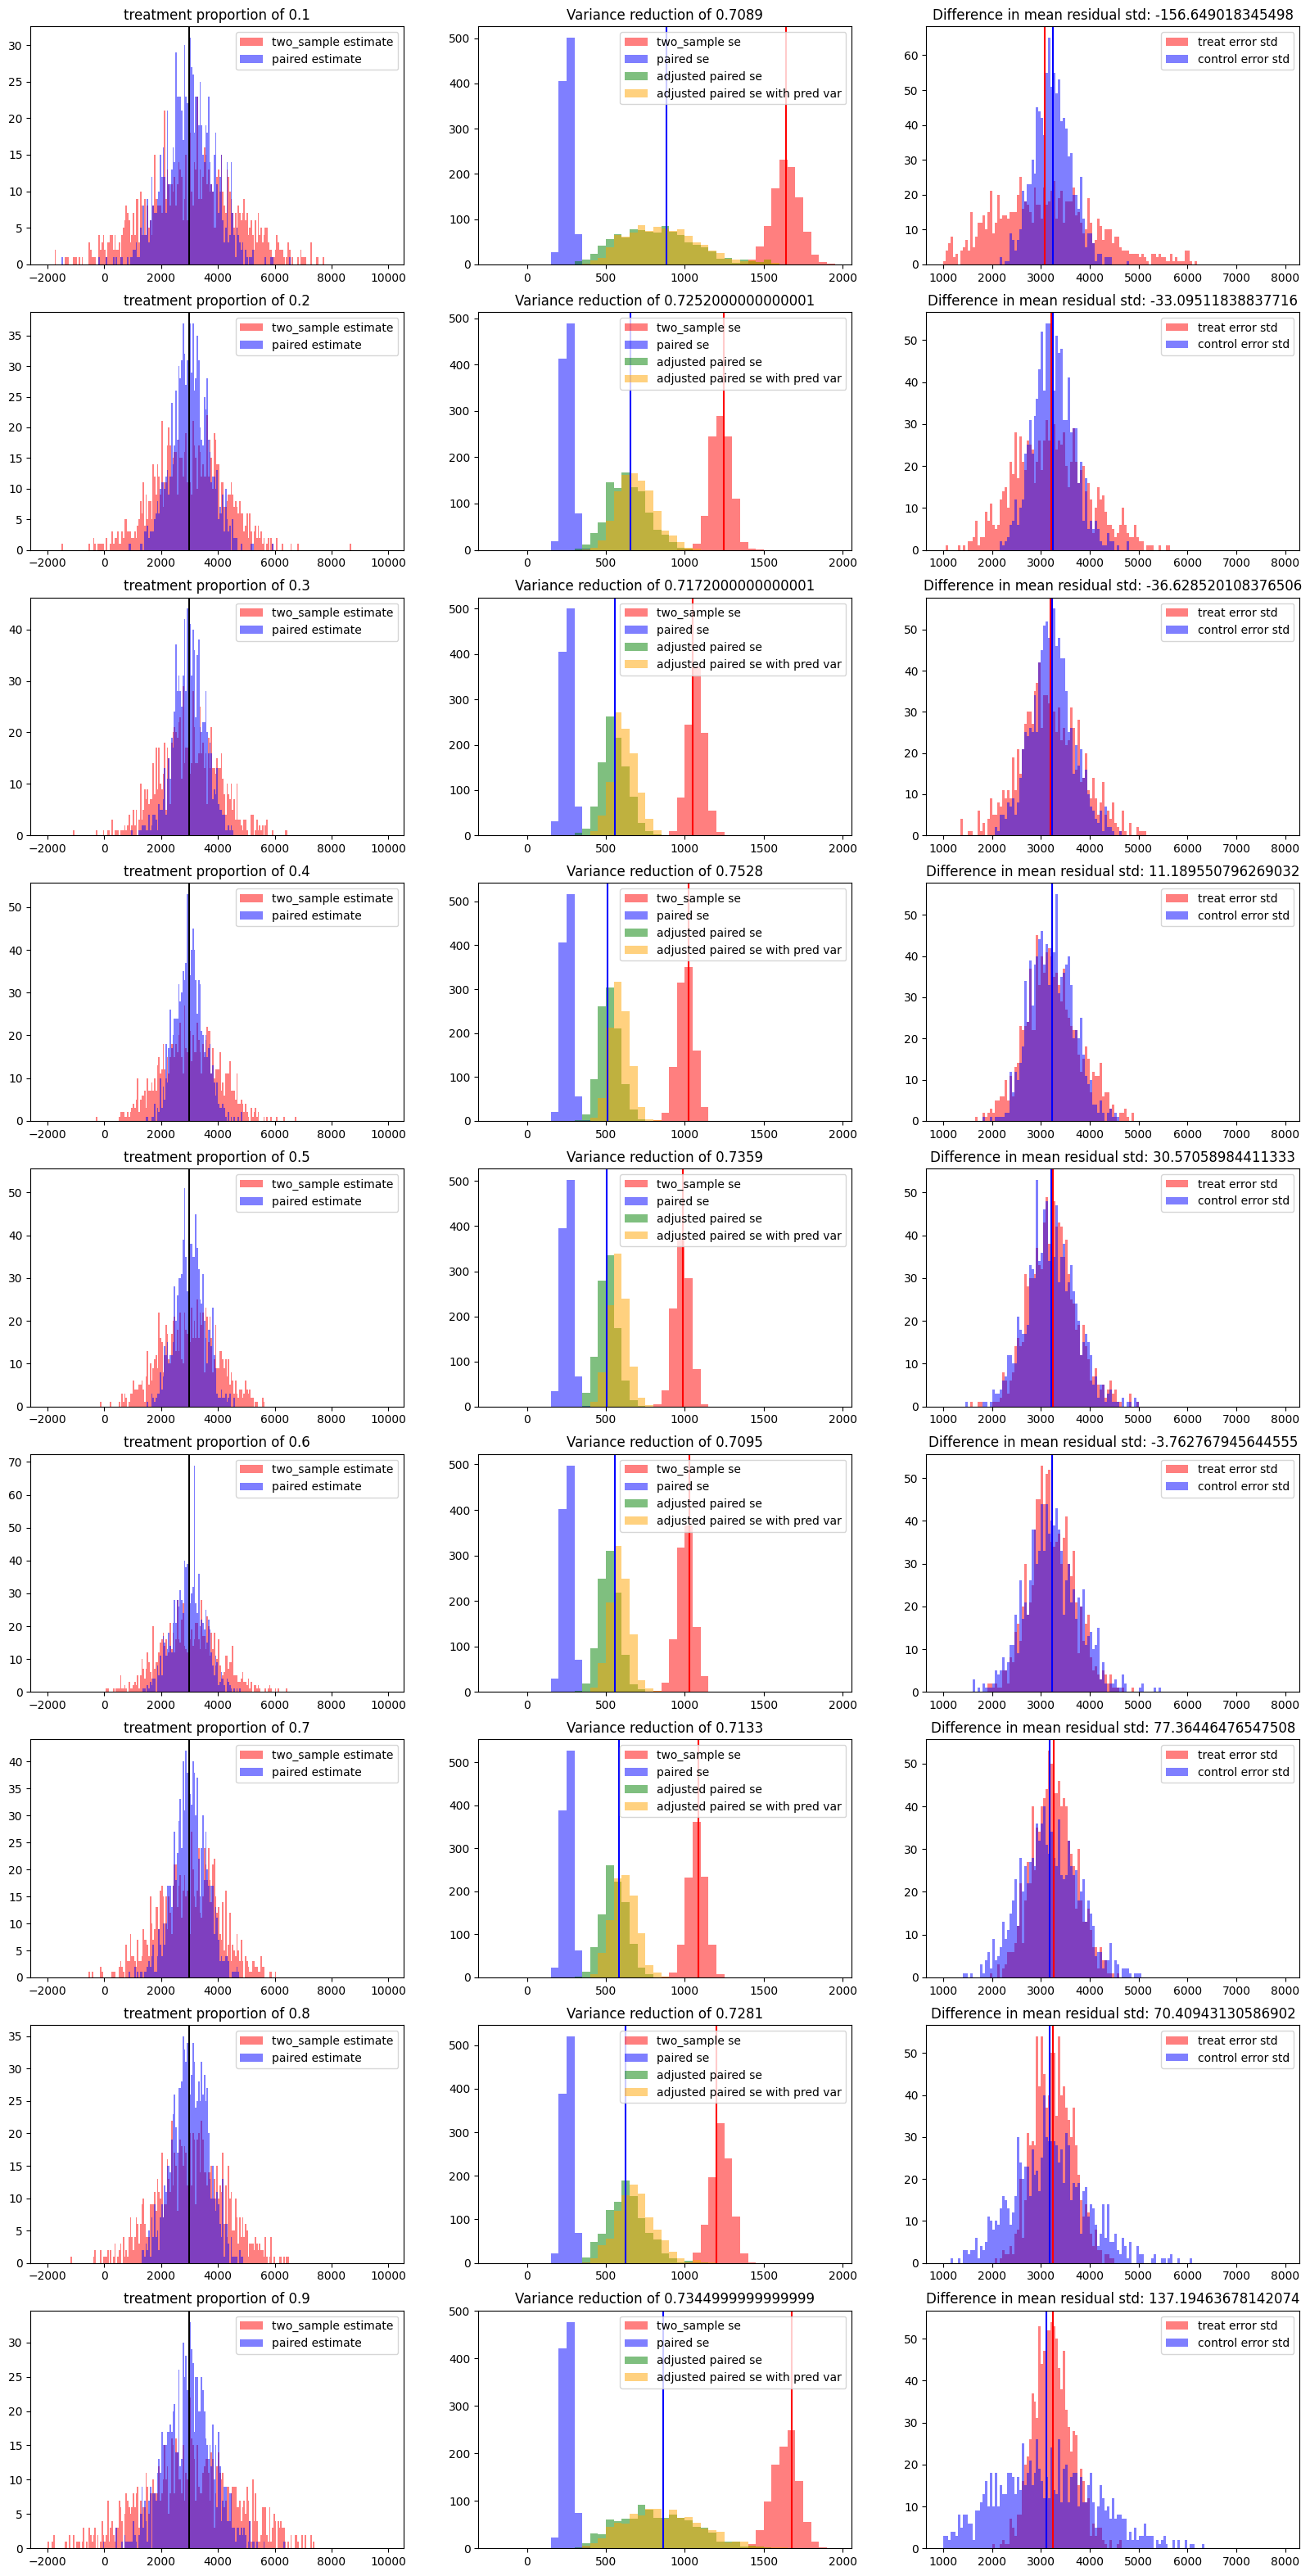

In [39]:
plt.rcParams['figure.figsize'] = [20, 40]
fig, ax = plt.subplots(len(treat_prop), 3)
for j in range(len(treat_prop)):
    sim_res = sim_res_df_dic[treat_prop[j]]
    ax[j,0].hist(sim_res['two_est'], bins = range(-2000,10000,50), 
             alpha=0.5,  
             label='two_sample estimate', 
             color='red') # customized color parameter 

    ax[j,0].hist(sim_res['pair_est'], bins = range(-2000,10000,50),   
             alpha=0.5,  
             label='paired estimate', 
             color='blue') # customized color parameter 
    ax[j,0].axvline(te, color='black')
    ax[j,0].legend() 
    ax[j,0].set_title("treatment proportion of " + str(round(treat_prop[j],1)))

    ax[j,1].hist(sim_res['two_se'],  bins = range(-200,2000,50),   
             alpha=0.5,  
             label='two_sample se', 
             color='red') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se'],  bins = range(-200,2000,50), 
             alpha=0.5,  
             label='paired se', 
             color='blue') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se_est1'],bins = range(-200,2000,50), 
            alpha=0.5,
            label='adjusted paired se',
            color='green')
    ax[j,1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
    ax[j,1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
    
    # note that the plot is for SE, not variance. But, plotting variance really messes up the scale alot so using se instead. 
    ax[j,1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
    ax[j,1].hist(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                         + sim_res['treat_pred_var']/treat_size
                         + sim_res['control_pred_var']/control_size),
            bins = range(-200,2000,50), 
            alpha=0.5,
            label='adjusted paired se with pred var',
            color='orange')
    ax[j,1].legend() 
    ax[j,2].hist(np.sqrt(sim_res['error1']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

    ax[j,2].hist(np.sqrt(sim_res['error0']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
    ax[j,2].legend() 
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
    ax[j,2].set_title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

In [40]:
temp_res = []
for i in range(len(treat_prop)):
    treat_size = int(sample_size*treat_prop[i])
    control_size = sample_size - treat_size
    sim_res = sim_res_df_dic[treat_prop[i]]
    pair_se = np.std(sim_res['pair_est'],ddof=1)
    two_se = np.std(sim_res['two_est'],ddof=1)
    est_two_se_mean = np.mean(sim_res['two_se'])
    est_two_se_med = np.median(sim_res['two_se'])
    est_pair_se_mean = np.mean(sim_res['pair_se_est1'])
    est_pair_se_med = np.median(sim_res['pair_se_est1'])
    est_pair_se_mean_adj = np.mean(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                                            + sim_res['treat_pred_var']/treat_size
                                            + sim_res['control_pred_var']/control_size))
    est_pair_se_med_adj = np.median(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                                            + sim_res['treat_pred_var']/treat_size
                                            + sim_res['control_pred_var']/control_size))
    temp_res.append([two_se,
                     est_two_se_mean, est_two_se_med,
                     pair_se,
                     est_pair_se_mean, est_pair_se_med,
                     est_pair_se_mean_adj, est_pair_se_med_adj])
te_se_stat = pd.DataFrame(temp_res, columns = ['simulated_two_se',
                                              'estimated_two_se_mean','estimated_two_se_med',
                                               'simulated_pair_se',
                                              'estimated_pair_se_mean','estimated_pair_se_med',
                                              'estimated_pair_se_mean_adj','estimated_pair_se_med_adj'])
te_se_stat
                 

,simulated_two_se,estimated_two_se_mean,estimated_two_se_med,simulated_pair_se,estimated_pair_se_mean,estimated_pair_se_med,estimated_pair_se_mean_adj,estimated_pair_se_med_adj
0,1641.642191,1641.862438,1642.734104,885.772539,822.400168,808.179318,866.553067,851.189818
1,1246.282079,1228.768646,1229.391843,653.294729,640.278335,632.481611,671.810959,663.889392
2,1047.990983,1070.889636,1070.802462,557.265410,555.050447,547.530289,582.487403,575.023678
3,1021.978168,1004.962625,1005.017276,508.071529,523.145279,521.745239,548.658953,546.047608
4,987.284354,983.323411,982.546964,507.412743,511.954701,511.620863,537.189252,536.955291
5,1029.547108,1003.767012,1004.099067,554.904314,522.899442,522.723513,548.339599,546.849594
6,1086.201897,1073.582430,1073.064661,581.614917,555.067268,551.884325,582.447392,579.091561
7,1201.621436,1228.855344,1230.570385,626.536396,634.799688,630.964867,666.606201,661.904700
8,1675.249620,1637.207196,1639.689703,863.259863,827.924191,807.189132,871.550024,850.972518


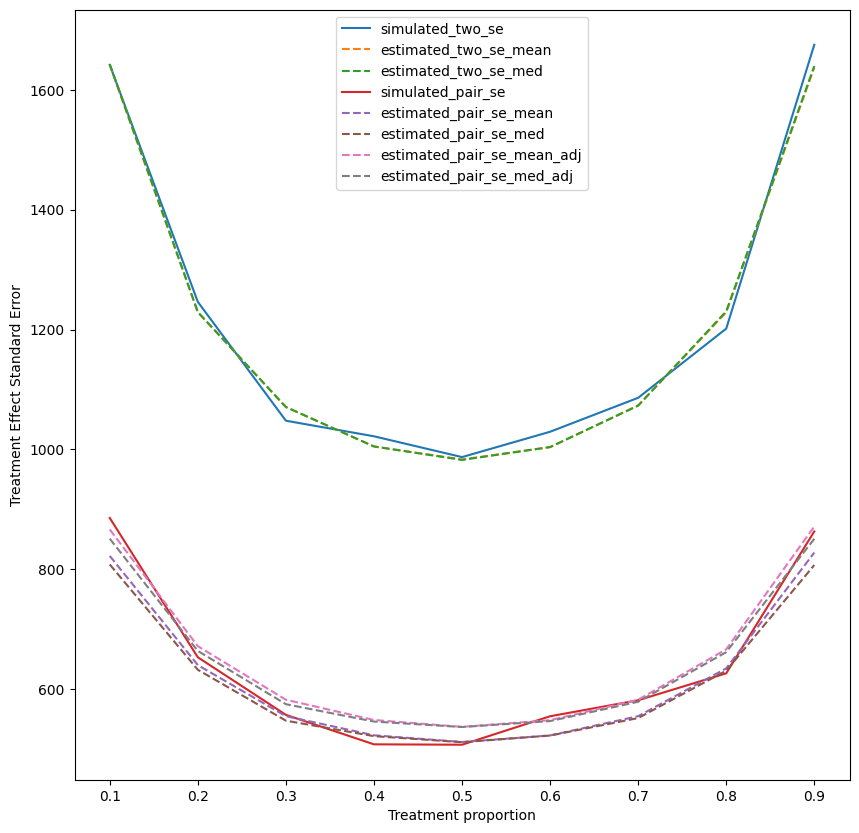

In [41]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(treat_prop, te_se_stat['simulated_two_se'], label = 'simulated_two_se')
plt.plot(treat_prop, te_se_stat['estimated_two_se_mean'], linestyle = "--", label = 'estimated_two_se_mean')
plt.plot(treat_prop, te_se_stat['estimated_two_se_med'], linestyle = "--", label = 'estimated_two_se_med')
plt.plot(treat_prop, te_se_stat['simulated_pair_se'], label = 'simulated_pair_se')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_mean'], linestyle = "--", label = 'estimated_pair_se_mean')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_med'], linestyle = "--", label = 'estimated_pair_se_med')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_mean_adj'], linestyle = "--", label = 'estimated_pair_se_mean_adj')
plt.plot(treat_prop, te_se_stat['estimated_pair_se_med_adj'], linestyle = "--", label = 'estimated_pair_se_med_adj')
plt.xlabel("Treatment proportion")
plt.ylabel("Treatment Effect Standard Error")
plt.legend()
plt.show()

In [42]:
# sample treatment effect  from a normal distribution with some variance
random.seed(1)
np.random.seed(1)
treat_prop = np.arange(0.1,1,0.1)
sample_size = 80 * 2 # this is the total sample size across both groups. before it was 80 per group but now 160 will be 
# distributed at different rates to each group
indx_range = range(0,len(y_test))
sim_res_df_dic = {}
mean_te = 3000
te_std = 500
for j in range(len(treat_prop)):
    temp_res = []
    treat_size = int(sample_size * treat_prop[j])
    control_size = sample_size - treat_size
    for i in range(num_preds):
        control_idx = random.choices(indx_range, k=control_size)
        treat_idx = random.choices(indx_range, k=treat_size)
        control_x = X_test[control_idx,]
        treat_x = X_test[treat_idx,]
        control_y = y_test[control_idx]
        treat_y = y_test[treat_idx] + stats.norm.rvs(size = treat_size, loc = mean_te, scale = te_std)
        predictions = pred_res[i]
        alpha1 = np.mean(treat_y - predictions[treat_idx])
        alpha0 = np.mean(control_y - predictions[control_idx])
        error1 = np.var(treat_y - predictions[treat_idx] - alpha1,ddof=1)
        error0 = np.var(control_y - predictions[control_idx] - alpha0,ddof=1)
        synt_treat_obs = predictions[control_idx] + alpha1
        synt_control_obs = predictions[treat_idx] + alpha0
        se_est1 = (error1/treat_size + error0/control_size)**0.5
        combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
        combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
        two_sample_te = np.mean(treat_y) - np.mean(control_y)
        two_sample_se = ((1/treat_size + 1/control_size)
                         *(np.var(treat_y, ddof=1)*(treat_size-1) + np.var(control_y, ddof=1)*(control_size-1))
                         /(sample_size - 2))**0.5
        paired_te = np.mean(combined_treat - combined_control)
        paired_se = (np.var(combined_treat - combined_control,ddof=1)/sample_size)**0.5
        # calculate prediction variances to use, based on the observations sampled
        control_mean_pred_var = np.mean(prediction_vars[control_idx])
        treat_mean_pred_var = np.mean(prediction_vars[treat_idx])
        # store results
        temp_res.append([two_sample_te, two_sample_se, paired_te, paired_se, se_est1, alpha1, alpha0, error1, error0,
                        control_mean_pred_var, treat_mean_pred_var])
    sim_res_df_dic[treat_prop[j]] = pd.DataFrame(temp_res, columns=["two_est","two_se","pair_est","pair_se","pair_se_est1",
                                                  "alpha1","alpha0","error1","error0",
                                                  "control_pred_var","treat_pred_var"])

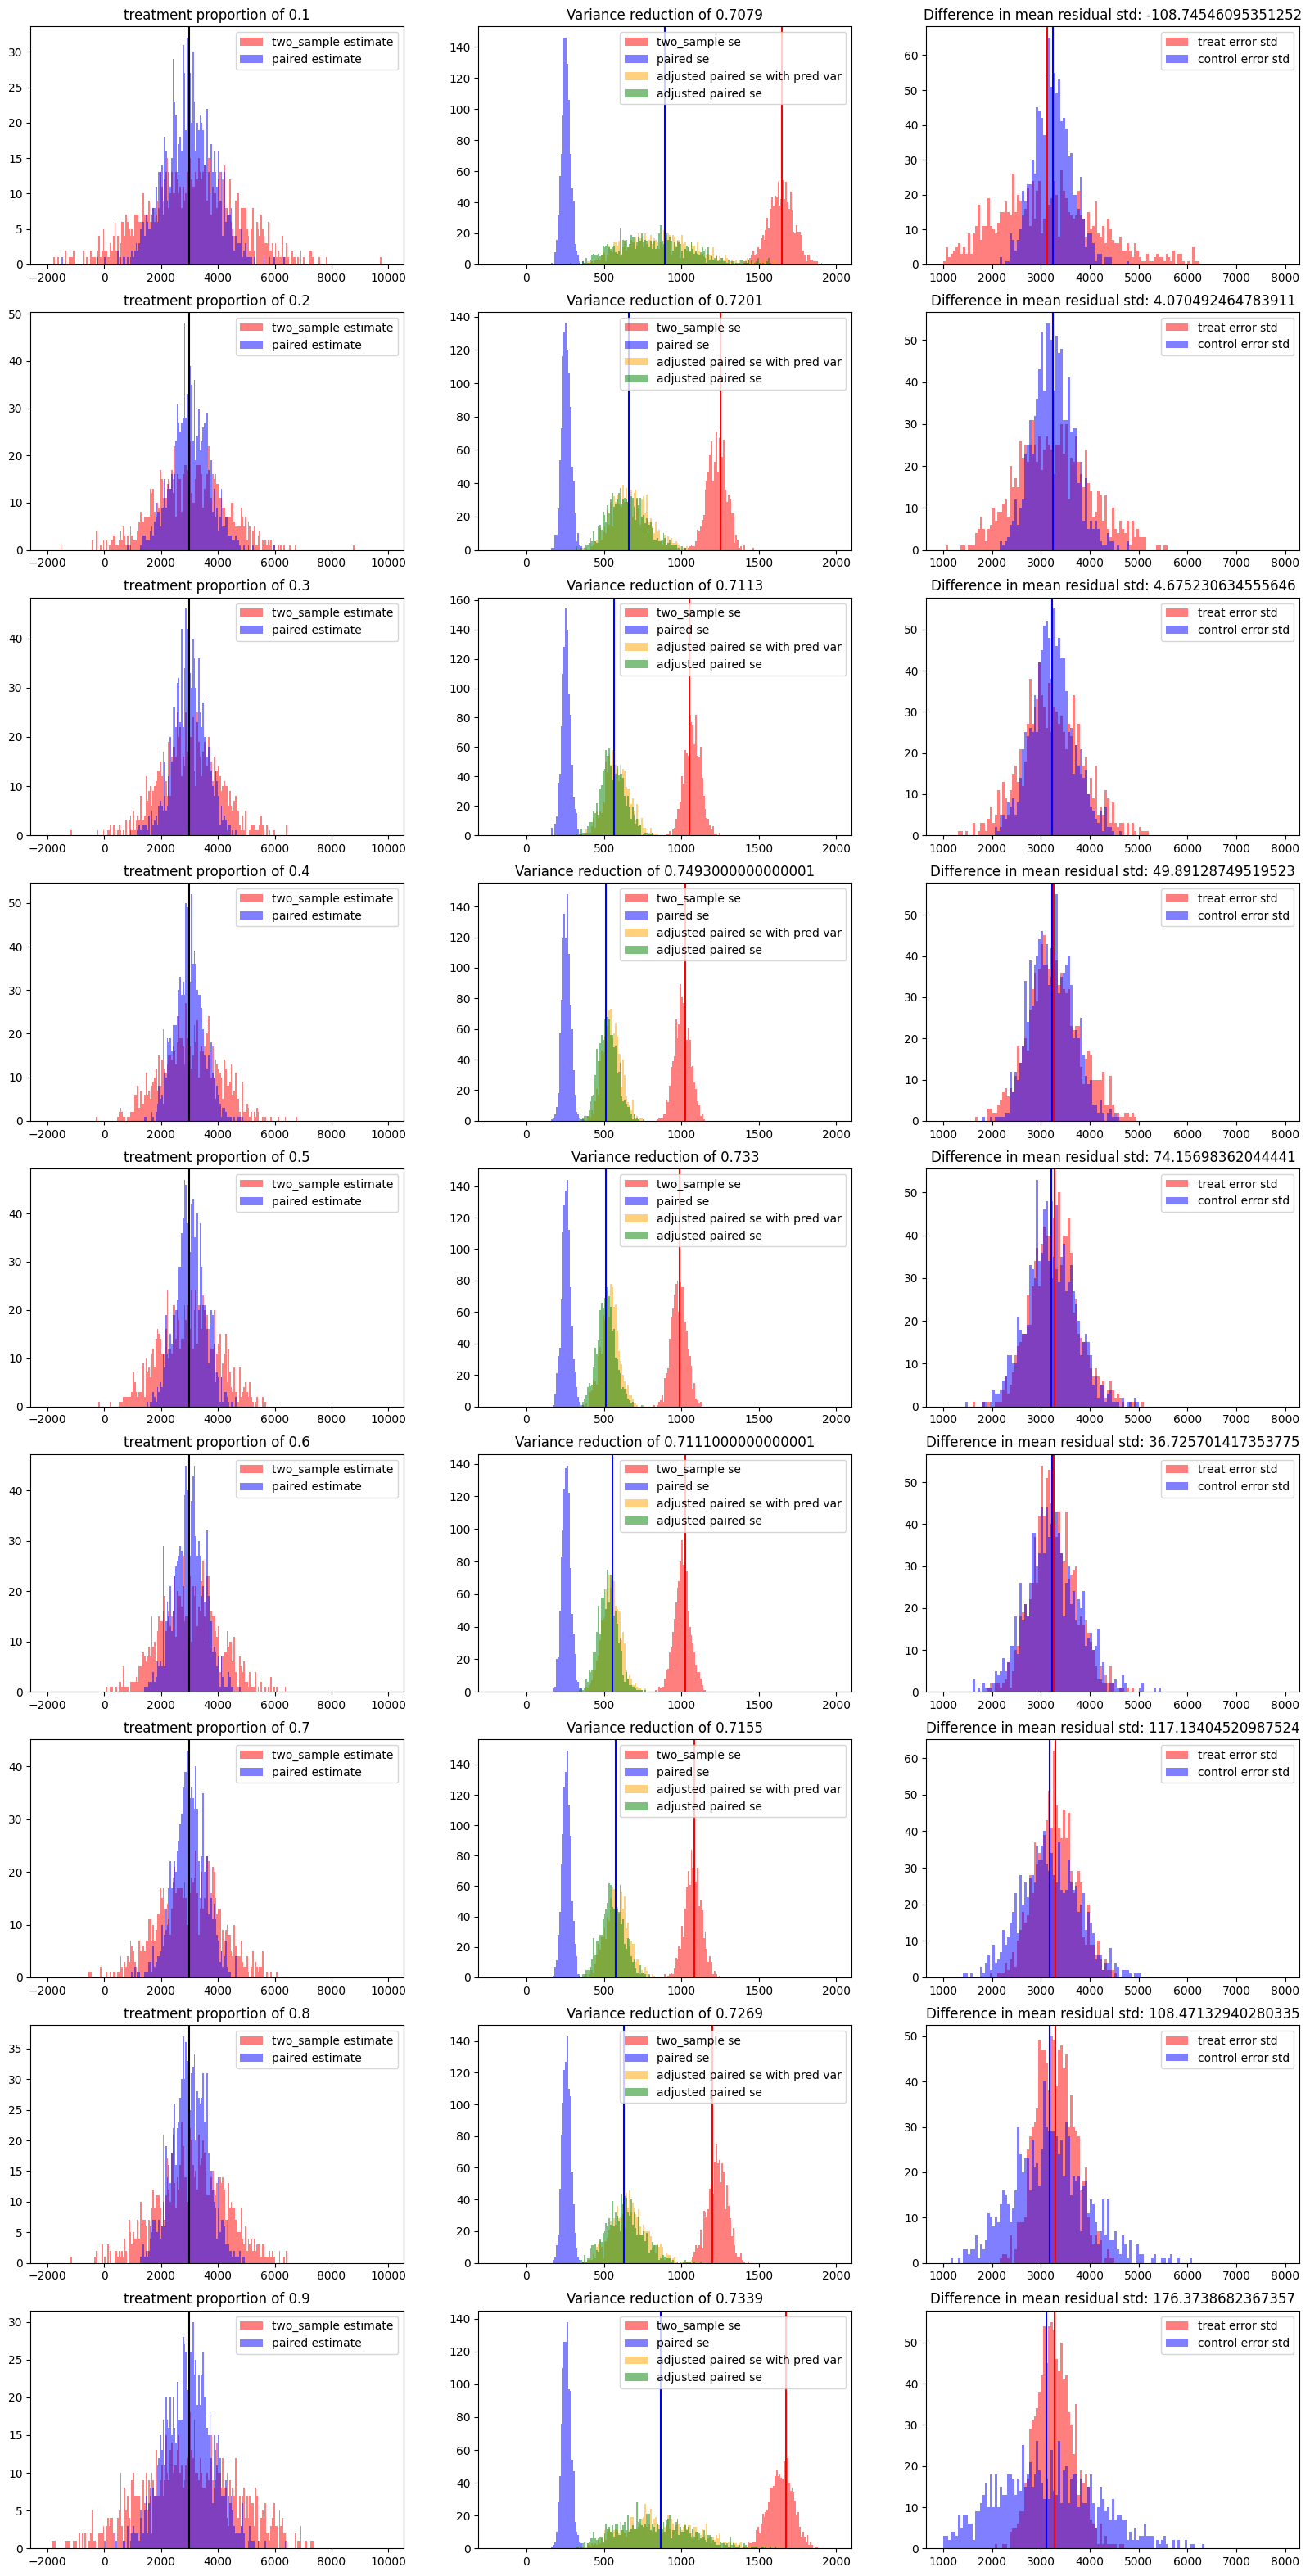

In [43]:
plt.rcParams['figure.figsize'] = [20, 40]
fig, ax = plt.subplots(len(treat_prop), 3)
for j in range(len(treat_prop)):
    sim_res = sim_res_df_dic[treat_prop[j]]
    ax[j,0].hist(sim_res['two_est'], bins = range(-2000,10000,50), 
             alpha=0.5,  
             label='two_sample estimate', 
             color='red') # customized color parameter 

    ax[j,0].hist(sim_res['pair_est'], bins = range(-2000,10000,50),   
             alpha=0.5,  
             label='paired estimate', 
             color='blue') # customized color parameter 
    ax[j,0].axvline(mean_te, color='black')
    ax[j,0].legend(loc='upper right') 

    ax[j,1].hist(sim_res['two_se'],  bins = range(-200,2000,10),   
             alpha=0.5,  
             label='two_sample se', 
             color='red') # customized color parameter 

    ax[j,1].hist(sim_res['pair_se'],  bins = range(-200,2000,10), 
             alpha=0.5,  
             label='paired se', 
             color='blue') # customized color parameter 
    treat_size = int(sample_size * treat_prop[j])
    control_size = sample_size - treat_size
    ax[j,1].hist(np.sqrt(np.power(sim_res['pair_se_est1'],2) 
                         + sim_res['treat_pred_var']/treat_size
                         + sim_res['control_pred_var']/control_size),
            bins = range(-200,2000,10), 
            alpha=0.5,
            label='adjusted paired se with pred var',
            color='orange')
    ax[j,1].hist(sim_res['pair_se_est1'],
            bins = range(-200,2000,10), 
            alpha=0.5,
            label='adjusted paired se',
            color='green')
    ax[j,1].legend(loc='upper right') 
    ax[j,1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
    ax[j,1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
    ax[j,0].set_title("treatment proportion of " + str(round(treat_prop[j],1)))
    ax[j,1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
    
    # check if variance/std of residuals are the same between control and treat group
    ax[j,2].hist(np.sqrt(sim_res['error1']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='treat error std', 
             color='red') # customized color parameter 

    ax[j,2].hist(np.sqrt(sim_res['error0']),  bins = range(1000,8000,50),
             alpha=0.5,  
             label='control error std', 
             color='blue') # customized color parameter 
    ax[j,2].legend(loc='upper right') 
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error1'])),color='red')
    ax[j,2].axvline(np.mean(np.sqrt(sim_res['error0'])),color='blue')
    ax[j,2].set_title("Difference in mean residual std: " + str(np.mean(np.sqrt(sim_res['error1']))-np.mean(np.sqrt(sim_res['error0']))))
plt.show() 

In [46]:
# generate multiple simulations with different group proportions
# simulating case where treatment is not randomly assigned across important covariate age
random.seed(1)
np.random.seed(1)
te = 0 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
o_X = X_test[age_mask,:] # features for older group
y_X = X_test[np.logical_not(age_mask),:] # features for younger group
o_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
y_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(o_y)) # number of rows from which to sample from older group
young_range = range(0, len(y_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size * 0.9) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx]
    o_control_y = o_y[o_control_idx]
    y_treat_y = y_y[y_treat_idx]
    y_control_y = y_y[y_control_idx]
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0) + te
    # select one of the predictions
    predictions = pred_res[i]
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # calculate params
    alpha1 = np.mean(treat_y - treat_preds)
    alpha0 = np.mean(control_y - control_preds)
    error1 = np.var(treat_y - treat_preds - alpha1, ddof=1)
    error0 = np.var(control_y - control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5

    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2, paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                              "pair_se_est1","pair_se_est2",
                                              "alpha1","alpha0","error1","error0"])

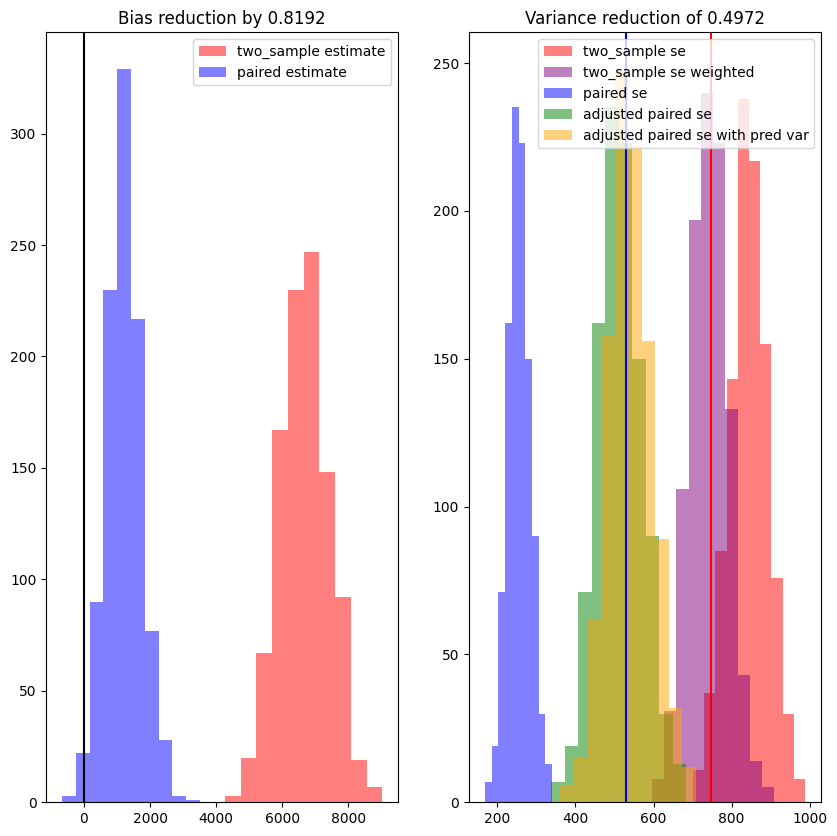

In [47]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-np.mean(sim_res['pair_est'])/np.mean(sim_res['two_est']),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
ax[1].hist(sim_res['two_se2'],  
         alpha=0.5,  
         label='two_sample se weighted', 
         color='purple') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')

ax[1].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var',
        color='orange')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
plt.show() 

In [48]:
# generate multiple simulations with different group proportions
# but the bias adjustment (alpha1 alpha0) is adjusting to the observed data which is disproportionately distributed.
# in this case, does not using alpha1 and alpha0 result in better bias reduction?
random.seed(1)
np.random.seed(1)
te = 0 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
o_X = X_test[age_mask,:] # features for older group
y_X = X_test[np.logical_not(age_mask),:] # features for younger group
o_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
y_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(o_y)) # number of rows from which to sample from older group
young_range = range(0, len(y_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size * 0.9) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx]
    o_control_y = o_y[o_control_idx]
    y_treat_y = y_y[y_treat_idx]
    y_control_y = y_y[y_control_idx]
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0) + te
    # select one of the predictions
    predictions = pred_res[i] + bias_est
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # calculate params
    alpha1 = 0 #np.mean(treat_y - treat_preds)
    alpha0 = 0 #np.mean(control_y - control_preds)
    error1 = np.var(treat_y - treat_preds - alpha1, ddof=1)
    error0 = np.var(control_y - control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5

    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2, paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0])
    
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                              "pair_se_est1","pair_se_est2",
                                              "alpha1","alpha0","error1","error0"])

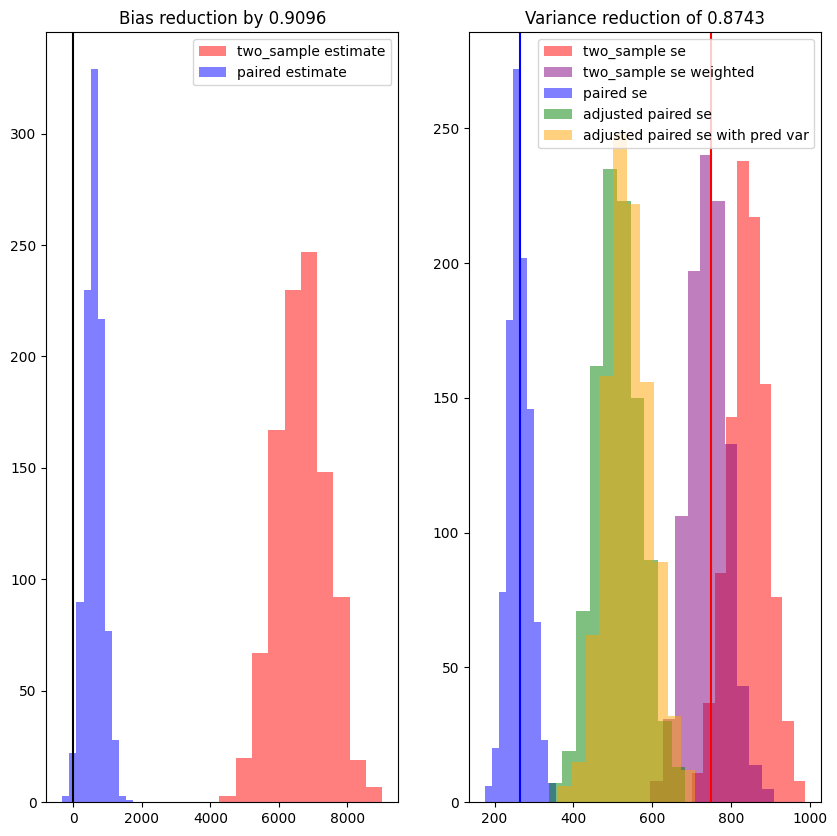

In [49]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,2)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-np.mean(sim_res['pair_est'])/np.mean(sim_res['two_est']),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter 
ax[1].hist(sim_res['two_se2'],  
         alpha=0.5,  
         label='two_sample se weighted', 
         color='purple') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 

ax[1].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se',
        color='green')

ax[1].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var',
        color='orange')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))
plt.show() 

In [51]:
# What if we calculate alpha1 and alpha0 on balanced subset, and THEN use these alphas to make adjustments to predictions? 

random.seed(134532)
np.random.seed(1543254)
te = 0 # perform A/A test first
sample_size = 80 # sample size PER group
treat_size = control_size = sample_size
temp_res = []
# divide up observatiosn to old and young groups and use stratified sampling
age_mask = X_test[:,0] >= 0 # boolean identifying older and younger groups
old_X = X_test[age_mask,:] # features for older group
young_X = X_test[np.logical_not(age_mask),:] # features for younger group
old_y = y_test[age_mask].reset_index(drop=True) # outcome for older group
young_y = y_test[np.logical_not(age_mask)].reset_index(drop=True) # outcome for younger group
old_range = range(0, len(old_y)) # number of rows from which to sample from older group
young_range = range(0, len(young_y)) # number of rows from which to sample from younger group
disprop_size = int(sample_size *0.9) # number of samples to be taken from older group to treatment
comp_size = sample_size - disprop_size # number of samples to be taken from younger group to treatment
for i in range(num_preds):
    # sample disprop from old for treat and from young for control
    # sample comp from old for control and from young for treat
    o_treat_idx = random.choices(range(0,len(o_y)),k=disprop_size)
    o_control_idx = random.choices(range(0,len(o_y)),k=comp_size)
    y_treat_idx = random.choices(range(0,len(y_y)),k=comp_size)
    y_control_idx = random.choices(range(0,len(y_y)),k=disprop_size)
    # extract rows corresponding to each group/age-split
    o_treat_X = o_X[o_treat_idx,]
    o_control_X = o_X[o_control_idx,]
    y_treat_X = y_X[y_treat_idx,]
    y_control_X = y_X[y_control_idx,]
    o_treat_y = o_y[o_treat_idx].reset_index(drop=True)
    o_control_y = o_y[o_control_idx].reset_index(drop=True)
    y_treat_y = y_y[y_treat_idx].reset_index(drop=True)
    y_control_y = y_y[y_control_idx].reset_index(drop=True)
    # group them together to one control and treatment groups
    control_X = np.append(o_control_X, y_control_X, axis=0)
    treat_X = np.append(o_treat_X, y_treat_X,axis=0)
    control_y = np.append(o_control_y,y_control_y,axis=0)
    treat_y = np.append(o_treat_y,y_treat_y,axis=0) + te
    # get a balanced subset from each group (sampled WITHOUT replacement, just getting a balanced subset of given sample)
    # in treat, there is small number of young obs compared to old obs. sample the same number of old obs as young obs from treatment group
    o_treat_bal = random.sample(range(len(o_treat_y)), k=comp_size)
    y_control_bal = random.sample(range(len(y_control_y)), k=comp_size)
    # balanced control and treat group on age
    bal_control_x = np.append(o_control_X, y_control_X[y_control_bal,], axis=0)
    bal_treat_x = np.append(o_treat_X[o_treat_bal,], y_treat_X, axis=0)
    bal_control_y = np.append(o_control_y, y_control_y[y_control_bal], axis=0)
    bal_treat_y = np.append(o_treat_y[o_treat_bal],y_treat_y, axis=0)
    # select one of the predictions
    predictions = pred_res[i]
    old_preds = predictions[age_mask]
    young_preds = predictions[np.logical_not(age_mask)]
    treat_preds = np.append(old_preds[o_treat_idx], young_preds[y_treat_idx], axis=0)
    control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_idx], axis=0)
    # balanced sample predictions for alpha calculation
    bal_treat_preds = np.append(old_preds[o_treat_bal], young_preds[y_treat_idx], axis=0)
    bal_control_preds = np.append(old_preds[o_control_idx], young_preds[y_control_bal], axis=0)
    # calculate params
    alpha1 = np.mean(bal_treat_y - bal_treat_preds)
    alpha0 = np.mean(bal_control_y - bal_control_preds)
    error1 = np.var(bal_treat_y - bal_treat_preds - alpha1, ddof=1)
    error0 = np.var(bal_control_y - bal_control_preds - alpha0, ddof=1)
    # generate artificial counterfactuals
    synt_treat_obs = control_preds + alpha1
    synt_control_obs = treat_preds + alpha0
    # variance estimate without prediction variance
    se_est1 = (error1/treat_size + error0/control_size)**0.5
    # variance estimate with prediction variance taken into account
    old_pred_vars = prediction_vars[age_mask].reset_index(drop=True)
    young_pred_vars = prediction_vars[np.logical_not(age_mask)].reset_index(drop=True)
    treat_pred_vars = np.append(old_pred_vars[o_treat_idx], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_idx],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est2 = (error1/treat_size + error0/control_size 
               + treat_mean_pred_var/treat_size + control_mean_pred_var/control_size)**0.5
    # combine obs for paired test
    combined_treat = np.concatenate((treat_y, synt_treat_obs),axis=None)
    combined_control = np.concatenate((synt_control_obs, control_y),axis=None)
    # two sample test results
    two_sample_te = np.mean(treat_y) - np.mean(control_y)
    #inaccurate se estimate, must weight it by group
    two_sample_se = (np.var(treat_y, ddof=1)/len(treat_y) + np.var(control_y,ddof=1)/len(control_y))**0.5
    treat_var = np.nan_to_num(np.var(o_treat_y,ddof=1)) * disprop_size / sample_size + np.nan_to_num(np.var(y_treat_y,ddof=1)) * comp_size / sample_size
    control_var = np.nan_to_num(np.var(o_control_y,ddof=1)) * comp_size / sample_size + np.nan_to_num(np.var(y_control_y,ddof=1)) * disprop_size / sample_size
    two_sample_se2 = (treat_var/sample_size + control_var/sample_size)**0.5
    # paired test results
    paired_te = np.mean(combined_treat - combined_control)
    paired_se = (np.var(combined_treat - combined_control,ddof=1)/(2*sample_size))**0.5
    # variance estimates with new sample size (comp_size)
    treat_pred_vars = np.append(old_pred_vars[o_treat_bal], young_pred_vars[y_treat_idx], axis=0)
    control_pred_vars = np.append(old_pred_vars[o_control_idx],young_pred_vars[y_control_bal],axis=0)
    control_mean_pred_var = np.mean(control_pred_vars)
    treat_mean_pred_var = np.mean(treat_pred_vars)
    se_est1b = (error1/(2*comp_size) + error0/(2*comp_size))**0.5
    se_est2b = (error1/(2*comp_size) + error0/(2*comp_size) 
               + treat_mean_pred_var/(2*comp_size) + control_mean_pred_var/(2*comp_size))**0.5
    # store results
    temp_res.append([two_sample_te, two_sample_se, two_sample_se2,
                     paired_te, paired_se, se_est1, se_est2,
                     alpha1, alpha0, error1, error0, se_est1b, se_est2b])
sim_res = pd.DataFrame(temp_res, columns=["two_est","two_se","two_se2","pair_est","pair_se",
                                          "pair_se_est1","pair_se_est2",
                                          "alpha1","alpha0","error1","error0",
                                          "pair_se_est1b", "pair_se_est2b"])

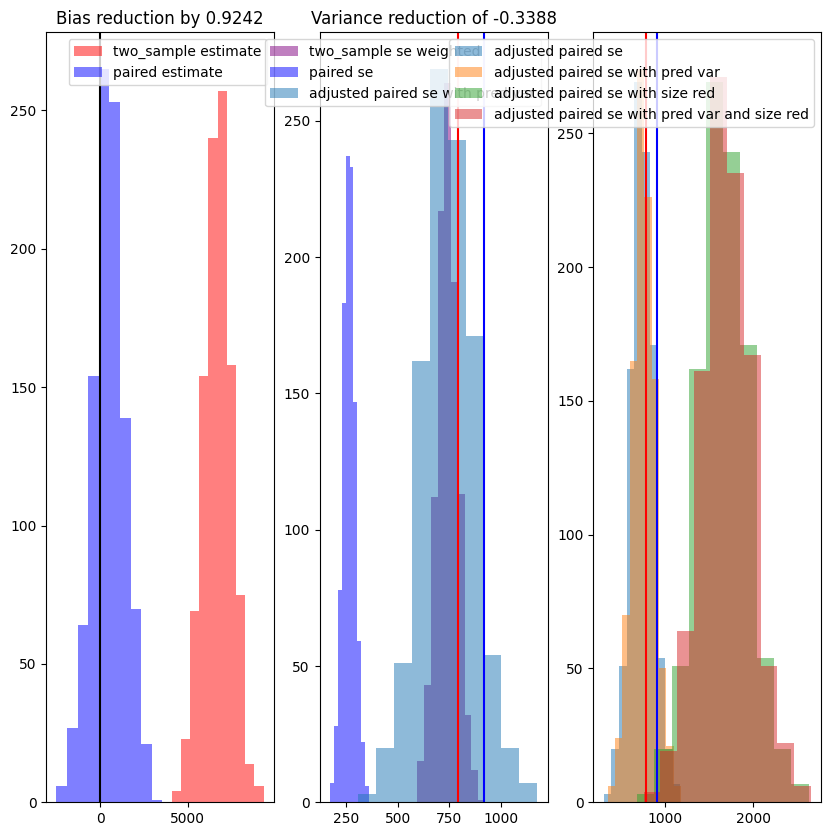

In [53]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots(1,3)
ax[0].hist(sim_res['two_est'],  
         alpha=0.5,  
         label='two_sample estimate', 
         color='red') # customized color parameter 
  
ax[0].hist(sim_res['pair_est'],  
         alpha=0.5,  
         label='paired estimate', 
         color='blue') # customized color parameter 
ax[0].axvline(te, color='black')
ax[0].legend(loc='upper right') 
bias_reduction_factor = round(1-abs(np.mean(sim_res['pair_est'])-te)/abs(np.mean(sim_res['two_est']-te)),4)
ax[0].set_title("Bias reduction by " + str(bias_reduction_factor))

'''ax[1].hist(sim_res['two_se'],  
         alpha=0.5,  
         label='two_sample se', 
         color='red') # customized color parameter '''
ax[1].hist(sim_res['two_se2'],  
         alpha=0.5,  
         label='two_sample se weighted', 
         color='purple') # customized color parameter 
  
ax[1].hist(sim_res['pair_se'],  
         alpha=0.5,  
         label='paired se', 
         color='blue') # customized color parameter 
'''ax[1].hist(sim_res['pair_se_est1'],
          alpha=0.5,
          label='adjusted paired se')'''
ax[1].hist(sim_res['pair_se_est1'],
          alpha=0.5,
          label='adjusted paired se with pred var')

ax[1].legend(loc='upper right') 
ax[1].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[1].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[1].set_title("Variance reduction of " + str(1 - round(np.var(sim_res["pair_est"], ddof=1)
                                                     /np.var(sim_res["two_est"], ddof=1),4)))

ax[2].hist(sim_res['pair_se_est1'],
        alpha=0.5,
        label='adjusted paired se')

ax[2].hist(sim_res['pair_se_est2'],
        alpha=0.5,
        label='adjusted paired se with pred var')
ax[2].hist(sim_res['pair_se_est1b'],
        alpha=0.5,
        label='adjusted paired se with size red')
ax[2].hist(sim_res['pair_se_est2b'],
        alpha=0.5,
        label='adjusted paired se with pred var and size red')
ax[2].axvline(np.std(sim_res['two_est'],ddof=1), color='red')
ax[2].axvline(np.std(sim_res['pair_est'],ddof=1), color='blue')
ax[2].legend()
plt.show() 

Similar to Inverse Propensity Weighting (IPW), can reduce bias but explodes in variance which lowers power and increase necessary sample size. Maybe the goal should be to just reduce variance on a randomized data where two samples are roughly balanced, but can be even better balanced with artificial counterfactuals.